In [2]:
from models.model import DBNet
import matplotlib.pyplot as plt
import torch
from torch.nn import BCELoss, L1Loss
from data.dataloader import get_loaders
from data.dataset import SimpleICDR2015Dataset
import cv2 as cv
from data.process.utils import resize_image
from tqdm import tqdm
import numpy as np
from shapely.geometry import Polygon
from models.utils import get_seg_and_poly

%load_ext autoreload
%autoreload 2

## Visualize new FAST dataset

In [3]:
dset = SimpleICDR2015Dataset('data')

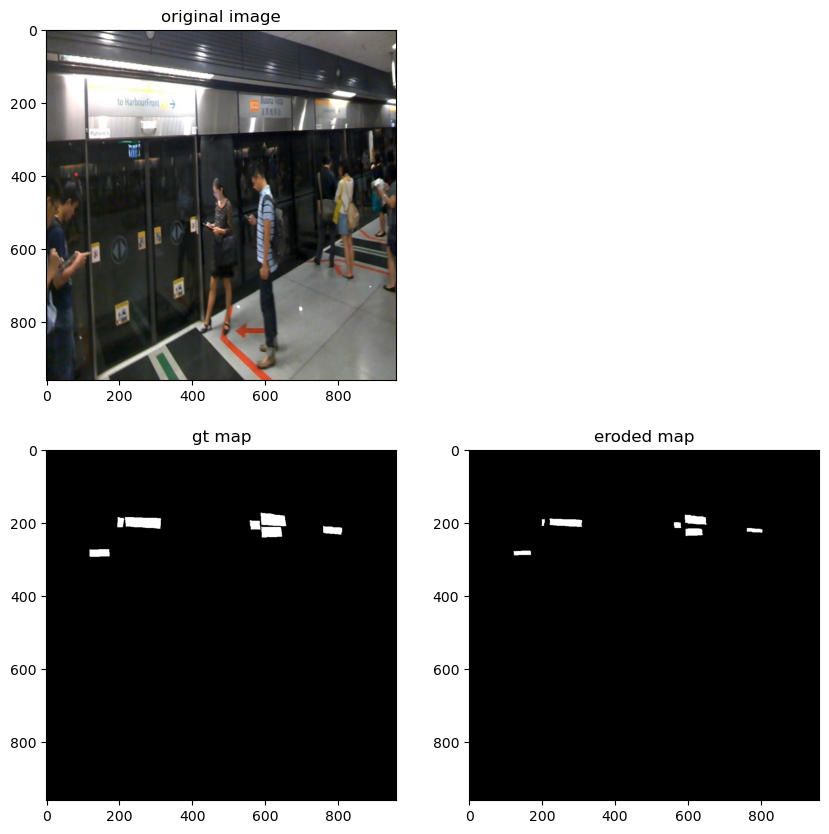

In [6]:
image, maps = dset[1]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.delaxes(axs[0][1])

axs[0][0].set_title('original image')
axs[0][0].imshow(image)
axs[1][0].set_title('gt map')
axs[1][0].imshow(maps['gt_map'], vmin=0, vmax=1, cmap='gray')
axs[1][1].set_title('eroded map')
axs[1][1].imshow(maps['eroded_map'], vmin=0, vmax=1, cmap='gray')

## Evaluation functions

In [2]:
bin_loss_fn = BCELoss()
prob_loss_fn = BCELoss()
thresh_loss_fn = L1Loss()
out_loss_fn = BCELoss()

def db_loss(pred, gt):
    bin_loss = bin_loss_fn(pred["bin_map"], gt["bin_map"])
    print('bin -', bin_loss.item())
    prob_loss = prob_loss_fn(pred["prob_map"], gt["bin_map"])
    print('prob -', prob_loss.item())
    thresh_loss = thresh_loss_fn(pred["thresh_map"], gt["thresh_map"])
    print('thresh -', thresh_loss.item())
    loss = prob_loss + bin_loss + 10 * thresh_loss
    print('total -', loss.item())
    return loss

In [3]:
def get_avg_loss(model, loader):
    running_loss = 0.0
    running_out_loss = 0.0
    dataset_size = 0


    for img, maps in tqdm(loader):
        batch_size = img.shape[0]

        output = model(img)

        bin_map = maps['bin_map']
        bin_loss = bin_loss_fn(output['bin_map'], bin_map)

        _, gt_maps = get_seg_and_poly(output['prob_map'])
        gt_maps = torch.from_numpy(gt_maps).to(device='cuda')
        out_loss = out_loss_fn(gt_maps, maps['gt_map'].to(device='cuda', dtype=torch.float32))

        running_loss += batch_size * bin_loss.item()
        running_out_loss += batch_size * out_loss.item()
        dataset_size += batch_size
    return running_loss / dataset_size, running_out_loss / dataset_size

## Predictions vs ground truth

[Epoch 318]
bin - 0.01540385466068983
prob - 0.018541831523180008
thresh - 0.004594968166202307
total - 0.07989536970853806


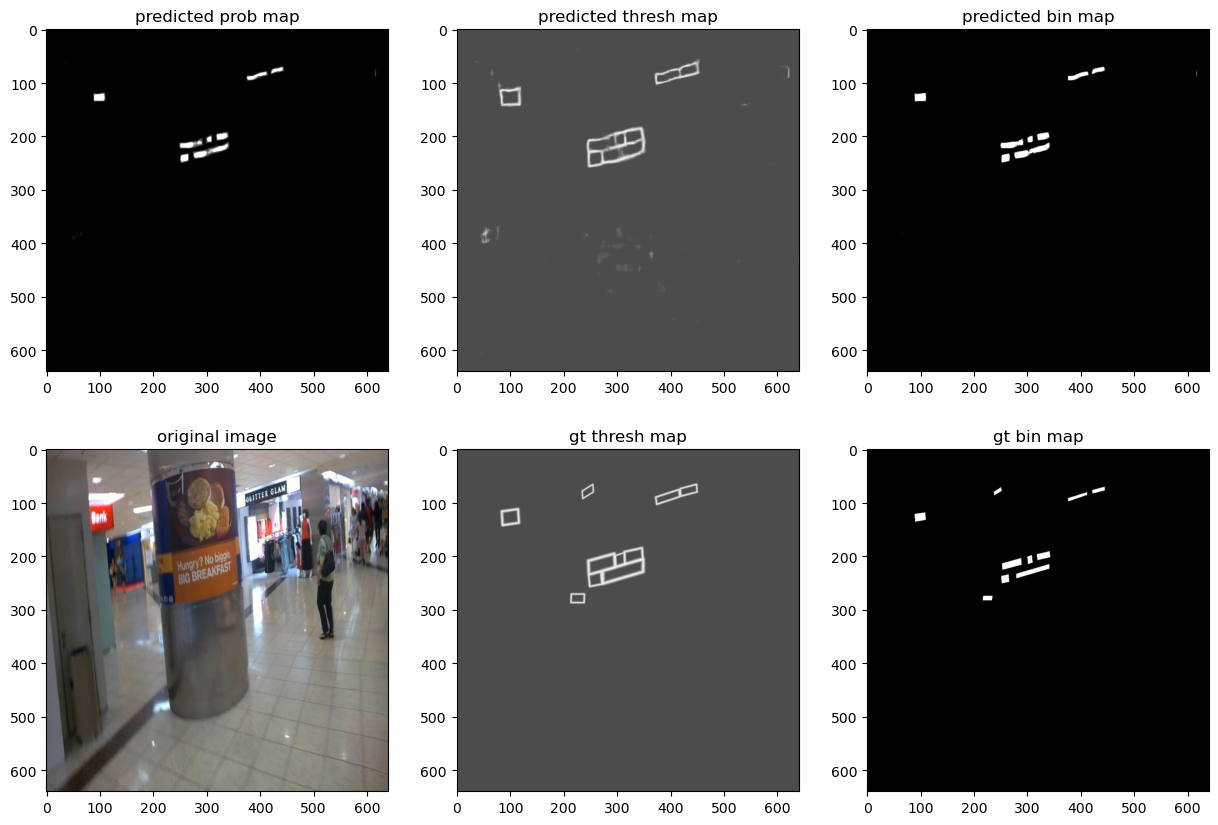

In [65]:
train_loader, val_loader = get_loaders('data', batch_size=1, train=False)

model = DBNet().cuda()
checkpoint = torch.load('models/checkpoints/dbnet_168', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f'[Epoch {checkpoint['epoch']}]')

imgs, maps = next(iter(val_loader))
img = imgs.to(device='cuda', dtype=torch.float32)
output = model(img)

for k, v in maps.items():
    maps[k] = v.to(device='cuda', dtype=torch.float32)
db_loss(output, maps)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0][0].imshow(output['prob_map'].detach().cpu().numpy().squeeze(), vmin=0, vmax=1, cmap='gray')
axs[0][0].set_title('predicted prob map')
axs[0][1].imshow(output['thresh_map'].detach().cpu().numpy().squeeze(), vmin=0, vmax=1, cmap='gray')
axs[0][1].set_title('predicted thresh map')
axs[0][2].imshow(output['bin_map'].detach().cpu().numpy().squeeze(), vmin=0, vmax=1, cmap='gray')
axs[0][2].set_title('predicted bin map')

un_img = torch.zeros_like(img[0])
un_img[0] = img[0][0] * 0.2262 * 255 + 0.3315 * 255
un_img[1] = img[0][1] * 0.2232 * 255 + 0.3530 * 255
un_img[2] = img[0][2] * 0.2290 * 255 + 0.3724 * 255
axs[1][0].imshow(((un_img - un_img.min()) / (un_img.max() - un_img.min())).permute(1, 2, 0).detach().cpu())
axs[1][0].set_title('original image')
axs[1][1].imshow(maps['thresh_map'].detach().cpu().numpy().squeeze(), vmin=0, vmax=1, cmap='gray')
axs[1][1].set_title('gt thresh map')
axs[1][2].imshow(maps['bin_map'].detach().cpu().numpy().squeeze(), vmin=0, vmax=1, cmap='gray')
axs[1][2].set_title('gt bin map')
plt.show()

In [45]:
x = torch.randn((1, 3, 640, 640)).cuda()
import time

In [47]:
from torchvision.models import resnet18, resnet50, resnet101, mobilenet_v3_small

In [59]:
m1 = resnet18().cuda()

In [70]:
s = time.time()
model(x)
time.time() - s

0.005232095718383789

## Dilated predictions vs ground truth

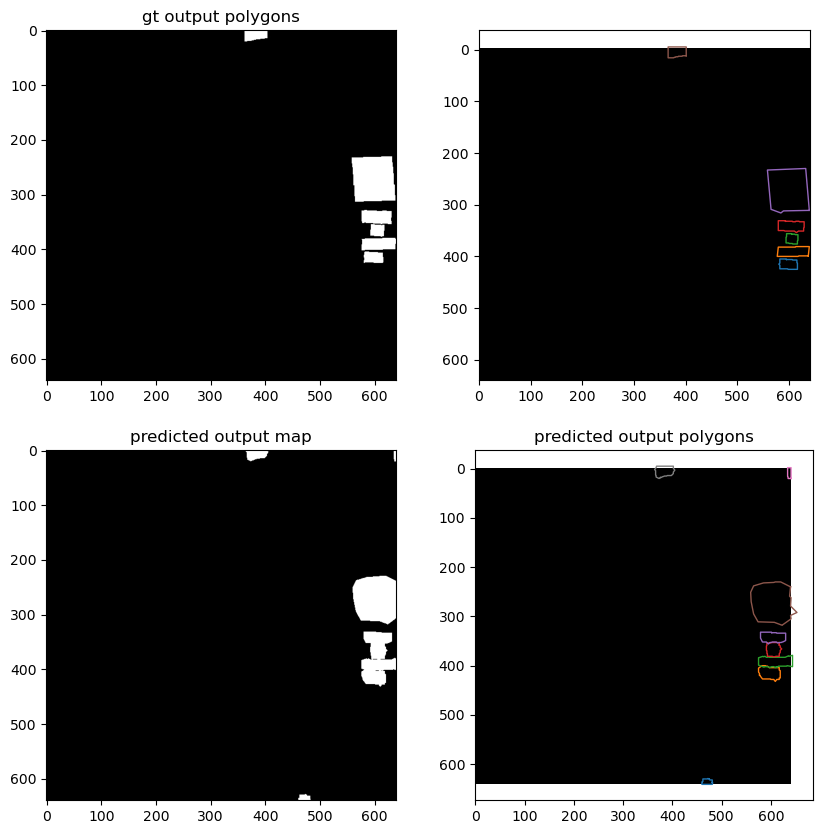

In [ ]:
polygons, gt_maps = get_seg_and_poly(output['prob_map'])
gt_polygons, _ = get_seg_and_poly(maps['bin_map'])

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].set_title('gt output map')
axs[0][0].imshow(maps['gt_map'].detach().cpu().squeeze(), cmap='gray')

axs[0][0].set_title('gt output polygons')
axs[0][1].imshow(np.zeros((640, 640)), cmap='gray')
for poly in gt_polygons[0]:
    Gs = Polygon(poly)
    axs[0][1].plot(*Gs.exterior.xy, linewidth=1)

axs[1][0].set_title('predicted output map')
axs[1][0].imshow(gt_maps.squeeze(), cmap='gray')

axs[1][1].set_title('predicted output polygons')
axs[1][1].imshow(np.zeros((640, 640)), cmap='gray')
for poly in polygons[0]:
    Gs = Polygon(poly)
    axs[1][1].plot(*Gs.exterior.xy, linewidth=1)
plt.show()

## Output loss evaluation

In [ ]:
avg_train_loss = get_avg_loss(model, train_loader)
avg_val_loss = get_avg_loss(model, val_loader)
avg_train_loss, avg_val_loss

  0%|          | 0/1200 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:05<00:00, 56.07it/s]


((0.01454436289301763, 0.9438366223352371),
 (0.033511262082029133, 1.7712889185796181))

## Real world example

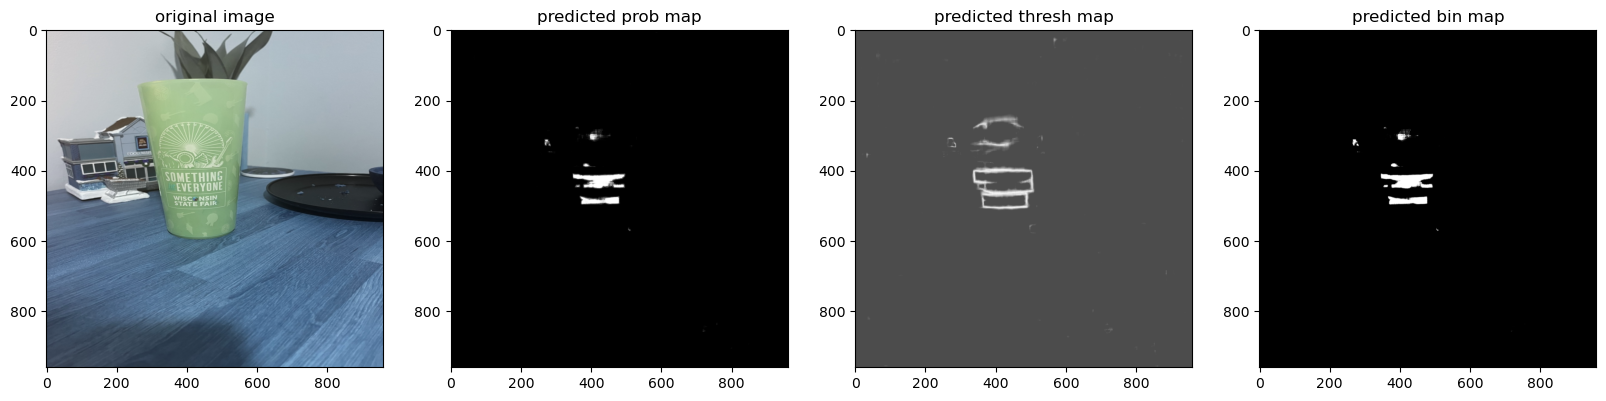

In [ ]:
img = cv.imread('../rsz_image.jpg', cv.IMREAD_UNCHANGED) / 255
img = resize_image(img)
img = torch.from_numpy(img)
img = img.to(device='cuda', dtype=torch.float32)
output = model(img.permute(2, 0, 1).unsqueeze(0))

fig, axs = plt.subplots(1, 4, figsize=(20, 10))

axs[0].imshow(((img - img.min()) / (img.max() - img.min())).detach().cpu())
axs[0].set_title('original image')
axs[1].imshow(output['prob_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[1].set_title('predicted prob map')
axs[2].imshow(output['thresh_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[2].set_title('predicted thresh map')
axs[3].imshow(output['bin_map'].detach().cpu().numpy()[0], vmin=0, vmax=1, cmap='gray')
axs[3].set_title('predicted bin map')
plt.show()